# Diabetes Prediction 

## Imports

In [1]:
# Data
import pandas as pd

# Visualization
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# Computation
import numpy as np

# Preprocessing
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Model and evaluation
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression

## Data 

The data set is composed of 9 columns of int and float types.<br>

- 'Pregnancies',
- 'Glucose',
- 'BloodPressure',
- 'SkinThickness',
- 'Insulin',
- 'BMI',
- 'DiabetesPedigreeFunction',
- 'Age',
- 'Outcome'

Important remark : the data concerns only woman

There are no null values in our dataset. In the case there were null values, we would use look for strategies using Imputer method.



In [5]:
df = pd.read_csv('../data/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [9]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [ ]:
##

Columns of the dataset

In [14]:
df.columns.to_list()

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Outcome']

# Exploratory Data Analysis

In the following section, we will examine class balance, analyze data distributions, explore pairwise correlations, assess feature relationships and detect potential outliers.

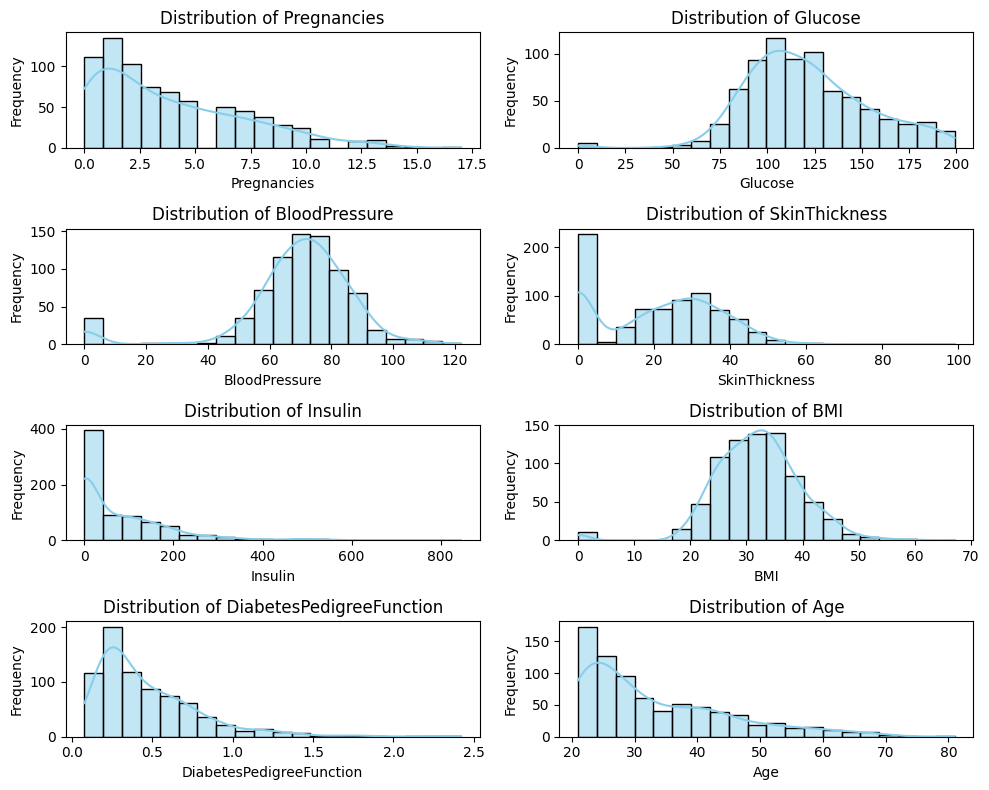

In [42]:
columns_for_plot = df.drop(columns=["Outcome"]).columns

fig, axes = plt.subplots(4, 2, figsize=(10, 8))

# Flatten axes for easier indexing
axes = axes.flatten()

# Plot histograms for each column
for i, col in enumerate(columns_for_plot):  
    sns.histplot(df[col], kde=True, color='skyblue', bins=20, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

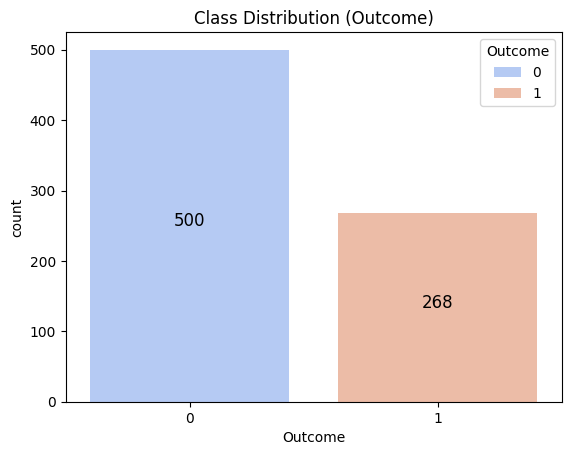

In [ ]:
# Class distribution
counts = df['Outcome'].value_counts()

# Plot class distribution
sns.countplot(x='Outcome', data=df, palette='coolwarm', hue='Outcome')
plt.title('Class Distribution (Outcome)')
plt.text(x=0, y=int(counts[0]/2), s=f"{counts[0]}", ha='center', fontsize=12)
plt.text(x=1, y=int(counts[1]/2), s=f"{counts[1]}", ha='center', fontsize=12)
plt.show()

**observation:** We observe class is **imbalanced**, there are more data samples of non-diabetic patients (class 0) compared to diabetic patients (class 1).<br>This imbalance can lead to biased model performance, where the model may favor predicting the majority class. To address this, we need to oversample the minority class (diabetic patients, class 1) to balance the dataset and improve model performance.


To address the class imbalance we will apply **SMOTE (Synthetic Minority Over-sampling Technique)**

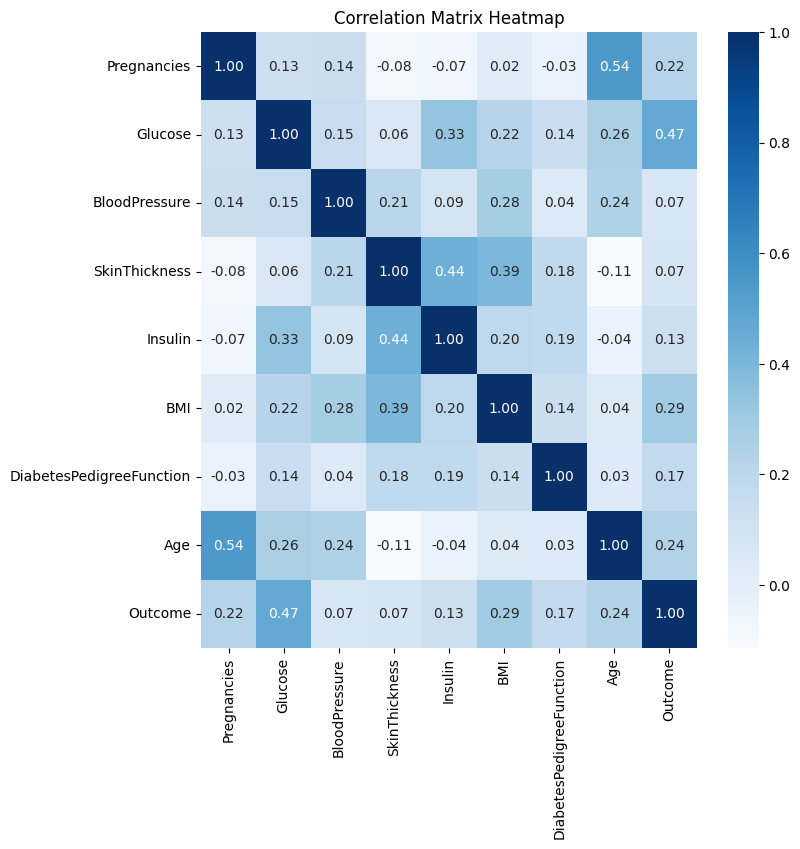

In [48]:
corr_matrix = df.corr()

# Heatmap of correlation matrix
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

The target 'Outcome' is less correlated with 'BloodPressure' and 'SkinThickness'. They are potential features to drop. 

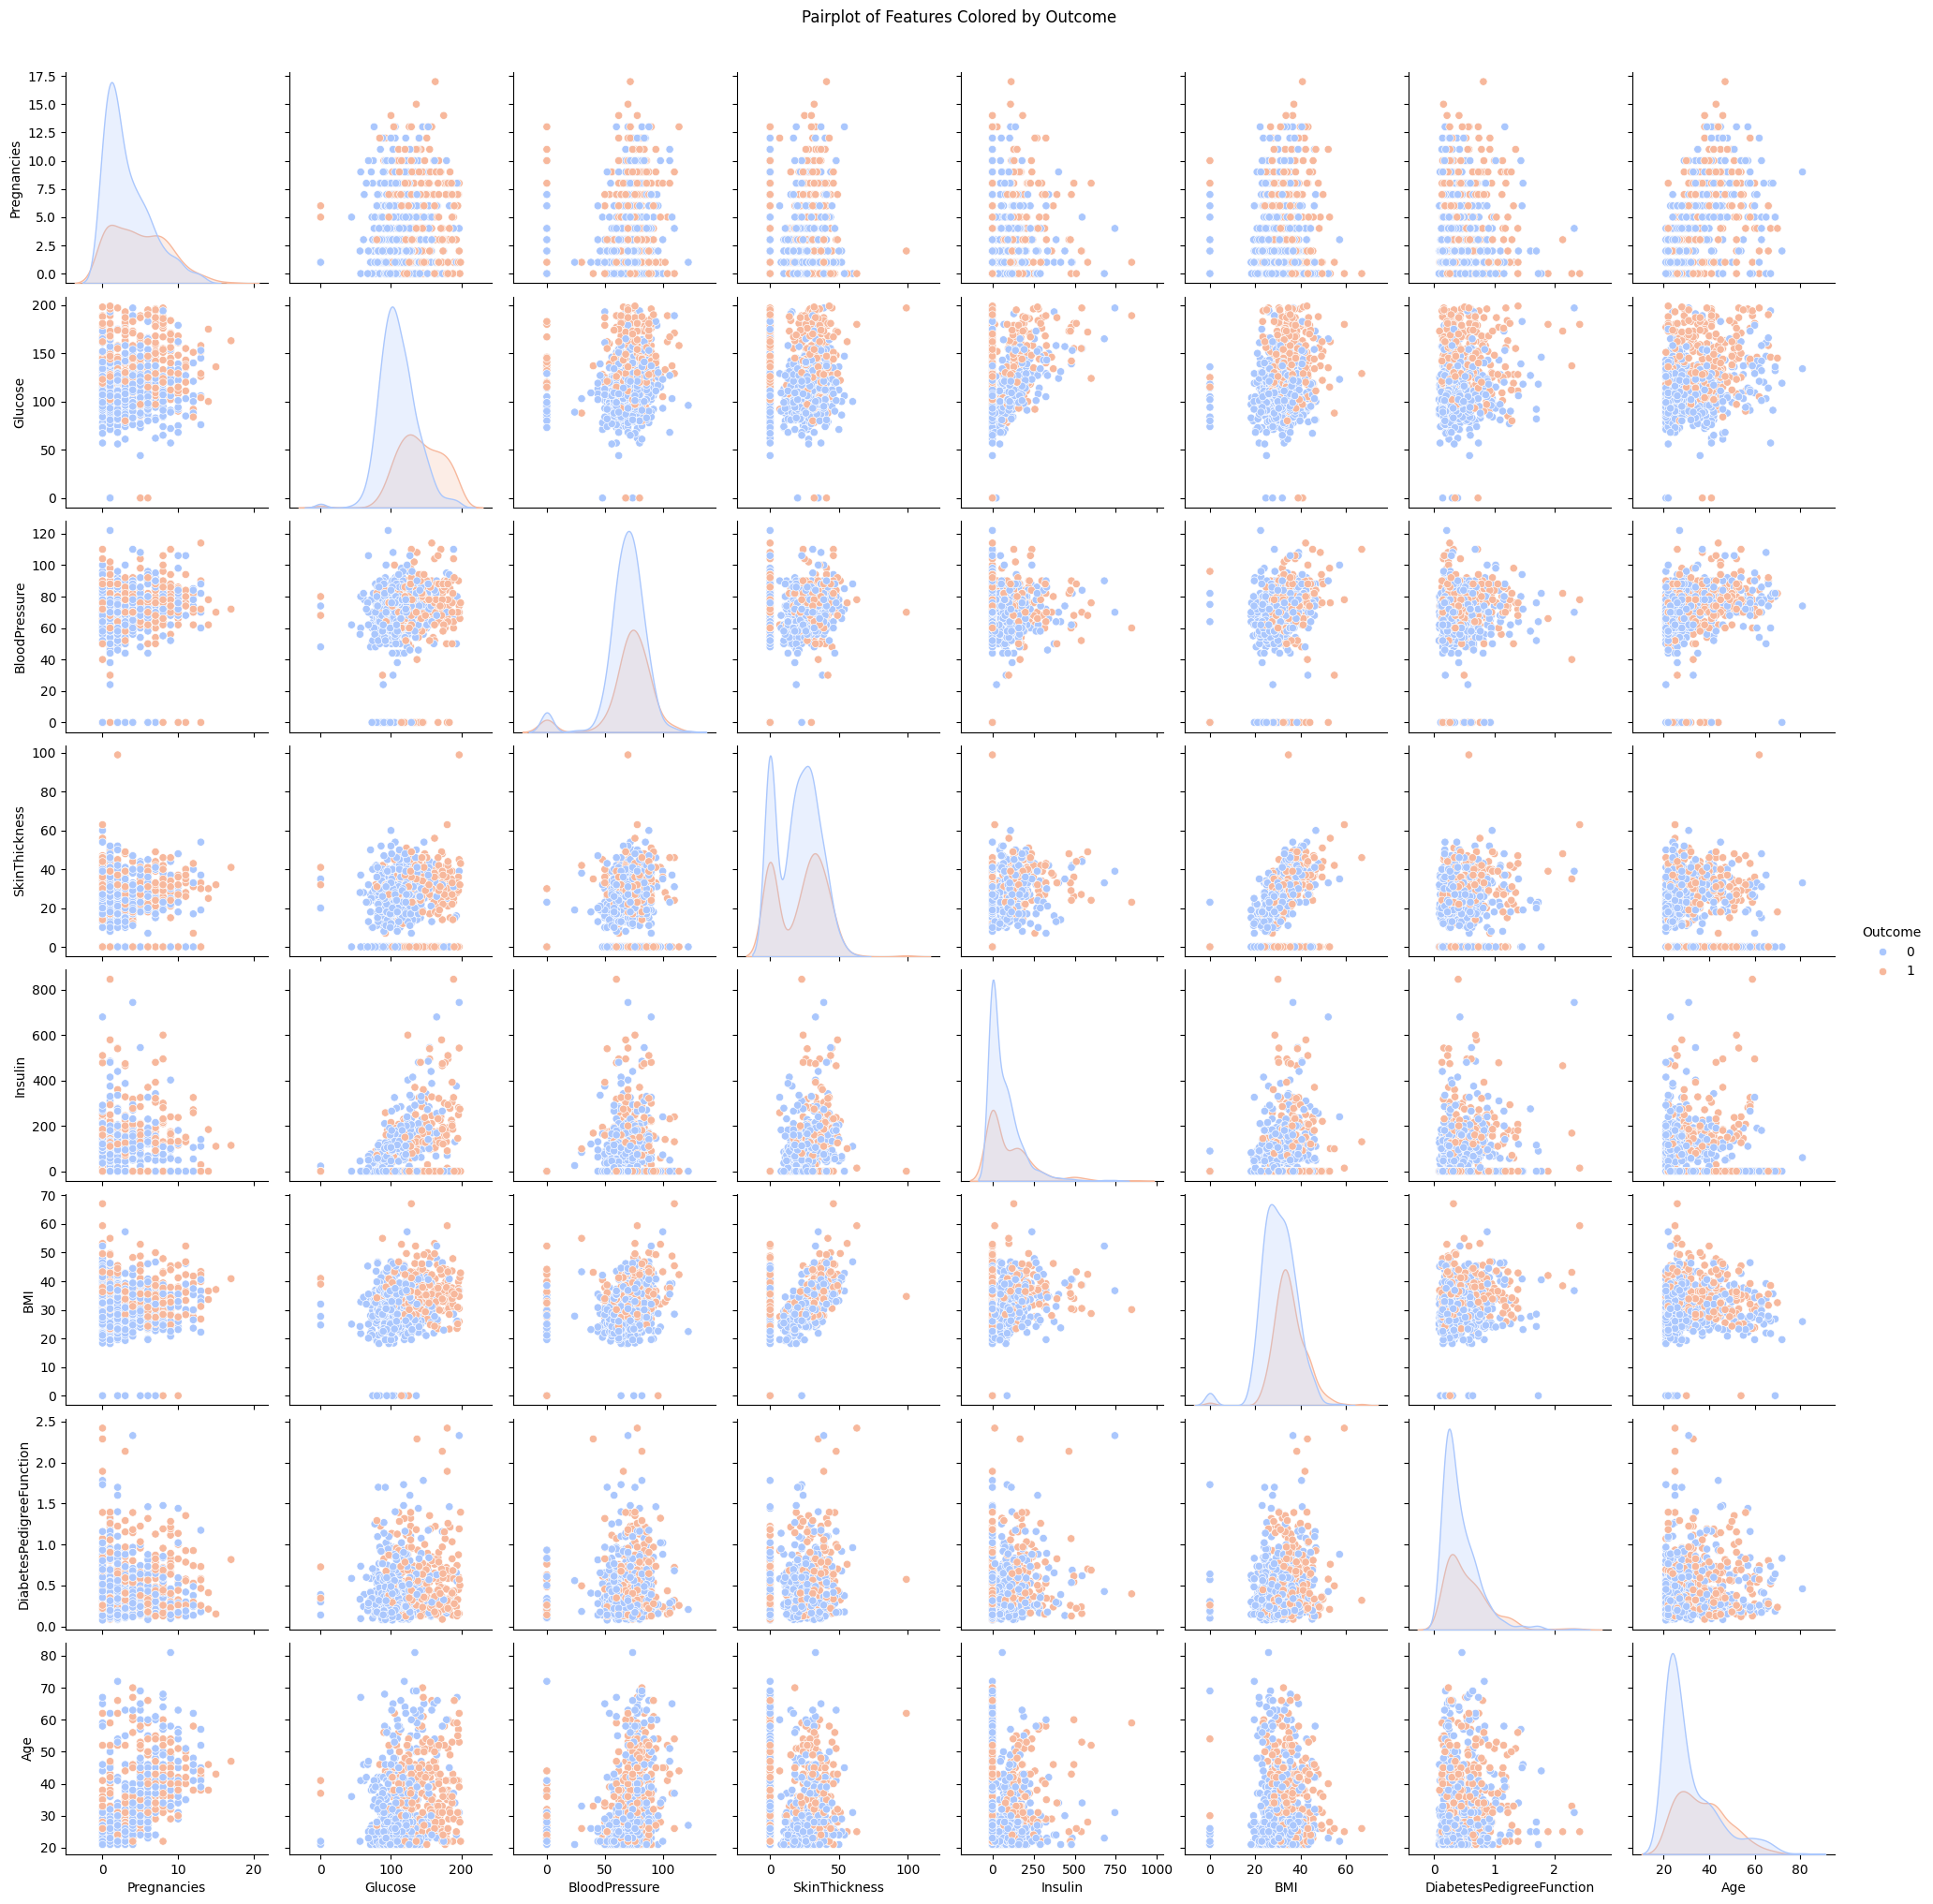

In [49]:
# Pairplot of numerical features
sns.pairplot(df, hue='Outcome', palette='coolwarm', diag_kind='kde')
plt.suptitle('Pairplot of Features Colored by Outcome', y=1.02)
plt.show()

In [59]:
# Boxplots for Outlier Detection (numerical features)
# Create a boxplot for each feature
fig = px.box(df, y=columns_for_plot, title="Boxplot of Features")
fig.show()


From the previous boxplot, it is clear that the primary outliers are from the "Insulin" feature, where the values are significantly higher.